# Create the CNN data from Pierre's dataframe

This code will generate each patient data as a tensor .pt. It will also create the attention version of the same image. A dataframe is created to connect the images to the patients

## 0. Settings

In [2]:
# Libraries
import os
from time import time

import pandas as pd
import numpy as np
import pickle

import torch

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import cv2

In [3]:
# Constants
PATH_TO_ARTERY_REGION_DF = "../../CVD_detection_code/Data_CVD/patient_2_view_info" # dataframe from pierre
PATH_TO_SAVE_NEW_IMGS = "processed_imgs/"

## 1. Create the df for images at artery level

In [4]:
region_level_df = pd.read_pickle(PATH_TO_ARTERY_REGION_DF)
region_level_df.sample(3)

,path_view1,path_view2,coord_view1,coord_view2,patient_name,segment_box,color_box,target_box
1229,/data/cardio/SPUM/Labelling_EPFL_CHUV/Farhang ...,/data/cardio/SPUM/Labelling_EPFL_CHUV/Farhang ...,"[[1515, 980], [1515, 350], [436, 350], [436, 9...","[[1170, 1102], [218, 691], [137, 878], [1089, ...",patient22,RCA,brown,0
401,/data/cardio/SPUM/Labelling_EPFL_CHUV/Farhang ...,/data/cardio/SPUM/Labelling_EPFL_CHUV/Farhang ...,"[[636, 324], [619, 216], [475, 239], [493, 347]]","[[576, 528], [553, 423], [438, 449], [461, 553]]",patient136,LCX,magenta,0
985,/data/cardio/SPUM/Labelling_EPFL_CHUV/Farhang ...,/data/cardio/SPUM/Labelling_EPFL_CHUV/Farhang ...,"[[617, 558], [617, 452], [506, 452], [506, 558]]","[[508, 502], [503, 400], [429, 404], [434, 506]]",patient198,LCX,yellow,0


In [5]:
len(region_level_df["patient_name"].unique())

469

In [6]:
# Adapt to our position
region_level_df["path_view1"] = region_level_df["path_view1"].str.replace('/data/cardio/SPUM', '../..')
region_level_df["path_view2"] = region_level_df["path_view2"].str.replace('/data/cardio/SPUM', '../..')
region_level_df["path_view1"] = region_level_df["path_view1"].str.replace('Z:/cardio/SPUM', '../..')
region_level_df["path_view2"] = region_level_df["path_view2"].str.replace('Z:/cardio/SPUM', '../..')
region_level_df["path_view1"] = region_level_df["path_view1"].str.replace('\\', '/', regex=False)
region_level_df["path_view2"] = region_level_df["path_view2"].str.replace('\\', '/', regex=False)

In [7]:
# We want the image without the boxes
region_level_df["path_view1"] = region_level_df["path_view1"].str[:-4]
region_level_df["path_view2"] = region_level_df["path_view2"].str[:-4]
region_level_df["path_view1"] = region_level_df["path_view1"] + " copie.tif"
region_level_df["path_view2"] = region_level_df["path_view2"] + " copie.tif"

region_level_df = region_level_df.drop(columns=["color_box"])

In [8]:
# When more than one view take the randomly one
artery_level_df = region_level_df.groupby(["patient_name","segment_box"]).agg({
    "path_view1": pd.Series.mode, 
    "path_view2": pd.Series.mode, 
    "coord_view1": list, 
    "coord_view2": list, 
    "target_box": pd.Series.max # if one of the images of a view has MI, they all contian MI
    })
artery_level_df.sample(3)

,,path_view1,path_view2,coord_view1,coord_view2,target_box
patient_name,segment_box,,,,,
patient320,RCA,../Labelling_EPFL_CHUV/Farhang NCL 2/476-287-2...,../Labelling_EPFL_CHUV/Farhang NCL 2/476-287-2...,"[[[1519, 1274], [1519, 959], [962, 959], [962,...","[[[1517, 1333], [1517, 676], [726, 676], [726,...",0
patient149,LCX,../Labelling_EPFL_CHUV/Farhang NCL/152-425-548...,../Labelling_EPFL_CHUV/Farhang NCL/152-425-548...,"[[[987, 234], [399, 50], [371, 142], [958, 326...","[[[1044, 373], [1042, 267], [687, 276], [690, ...",0
patient16,RCA,../Labelling_EPFL_CHUV/Farhang MI with or with...,../Labelling_EPFL_CHUV/Farhang MI with or with...,"[[[1448, 886], [1306, 435], [491, 692], [632, ...","[[[1448, 886], [1306, 435], [491, 692], [632, ...",0


In [18]:
list_ill_artery = artery_level_df[artery_level_df["target_box"]==1].reset_index().groupby("patient_name")["segment_box"].apply(list)

In [29]:
# Compute the MI repartition
artery_l = ["LAD", "LCX", "RCA"]
alone_artery_l = [0, 0, 0]
pair_artery_l = 0
all_artery = 0
for ill_artery in list_ill_artery:
    if len(ill_artery)==1:
        alone_artery_l[artery_l.index(ill_artery[0])] += 1
    elif len(ill_artery) == 2:
        pair_artery_l += 1
        print(ill_artery)
    elif len(ill_artery) == 3:
        all_artery += 1
        
print("\n", artery_l)
print(alone_artery_l)
print("\nTWO")
print(pair_artery_l)
print("\nALL")
print(all_artery)

['LCX', 'RCA']
['LAD', 'RCA']
['LAD', 'LCX']
['LAD', 'LCX']
['LAD', 'LCX']
['LAD', 'RCA']
['LAD', 'RCA']

 ['LAD', 'LCX', 'RCA']
[20, 12, 6]

TWO
7

ALL
2


In [11]:
artery_level_df = artery_level_df.reset_index().groupby(["patient_name"]).agg({
    "path_view1": list, 
    "path_view2": list, 
    "coord_view1": list, 
    "coord_view2": list, 
    "target_box": list
    })
artery_level_df.sample(3)

,path_view1,path_view2,coord_view1,coord_view2,target_box
patient_name,,,,,
patient419,[../Labelling_EPFL_CHUV/Farhang NCL 3/643-960-...,[../Labelling_EPFL_CHUV/Farhang NCL 3/643-960-...,"[[[[1045 285], [641 155], [614 240], [1018 3...","[[[[1045 285], [641 155], [614 240], [1018 3...","[0, 0, 0]"
patient214,[../Labelling_EPFL_CHUV/Farhang NCL/311-038-63...,[../Labelling_EPFL_CHUV/Farhang NCL/311-038-63...,"[[[[1272 1431], [1087 115], [747 163], [ 932 ...","[[[[1576 472], [650 68], [579 233], [1504 6...","[0, 0, 0]"
patient206,[../Labelling_EPFL_CHUV/Farhang NCL/258-427-87...,[../Labelling_EPFL_CHUV/Farhang NCL/258-427-87...,"[[[[1032 1462], [739 196], [646 218], [ 938 14...","[[[[814 291], [737 166], [ 48 592], [125 717]]...","[0, 0, 0]"


In [12]:
# Remove patients that don't have three information for each feature (LAD, LCX, RCA)
print("Nb patients before {}".format(len(artery_level_df)))

patients_to_remove = artery_level_df[artery_level_df["path_view1"].map(len)!=3].index
patients_to_remove.append(artery_level_df[artery_level_df["path_view2"].map(len)!=3].index)
patients_to_remove.append(artery_level_df[artery_level_df["coord_view1"].map(len)!=3].index)
patients_to_remove.append(artery_level_df[artery_level_df["coord_view2"].map(len)!=3].index)
patients_to_remove.append(artery_level_df[artery_level_df["target_box"].map(len)!=3].index)

artery_level_df_dropped = artery_level_df.loc[patients_to_remove]
artery_level_df = artery_level_df.drop(patients_to_remove)
print("Nb patients after {}".format(len(artery_level_df)))

Nb patients before 469
Nb patients after 446


In [13]:
artery_level_df[["path_lad_1","path_lcx_1","path_rca_1"]] = pd.DataFrame(artery_level_df["path_view1"].tolist(), index= artery_level_df.index)
artery_level_df[["path_lad_2","path_lcx_2","path_rca_2"]] = pd.DataFrame(artery_level_df["path_view2"].tolist(), index= artery_level_df.index)
artery_level_df = artery_level_df.drop(columns=["path_view1", "path_view2"])

In [14]:
artery_level_df[["mi_lad","mi_lcx","mi_rca"]] = pd.DataFrame(artery_level_df["target_box"].tolist(), index= artery_level_df.index)
artery_level_df = artery_level_df.drop(columns=["target_box"])

In [15]:
artery_level_df["patient_mi"] = artery_level_df["mi_lad"] | artery_level_df["mi_lcx"] | artery_level_df["mi_rca"] 

In [16]:
artery_level_df[["boxes_lad_1","boxes_lcx_1","boxes_rca_1"]] = pd.DataFrame(artery_level_df["coord_view1"].tolist(), index= artery_level_df.index)
artery_level_df[["boxes_lad_2","boxes_lcx_2","boxes_rca_2"]] = pd.DataFrame(artery_level_df["coord_view2"].tolist(), index= artery_level_df.index)
artery_level_df = artery_level_df.drop(columns=["coord_view1", "coord_view2"])

In [17]:
for col in artery_level_df.columns:
    artery_level_df.loc[artery_level_df[col].apply(type) == np.ndarray, col] = artery_level_df.loc[artery_level_df[col].apply(type) == np.ndarray, col].apply(lambda x:x[0])

In [18]:
artery_level_df.sample(3)

,path_lad_1,path_lcx_1,path_rca_1,path_lad_2,path_lcx_2,path_rca_2,mi_lad,mi_lcx,mi_rca,patient_mi,boxes_lad_1,boxes_lcx_1,boxes_rca_1,boxes_lad_2,boxes_lcx_2,boxes_rca_2
patient_name,,,,,,,,,,,,,,,,
patient377,../Labelling_EPFL_CHUV/Farhang NCL 2/588-178-5...,../Labelling_EPFL_CHUV/Farhang NCL 2/588-178-5...,../Labelling_EPFL_CHUV/Farhang NCL 2/588-178-5...,../Labelling_EPFL_CHUV/Farhang NCL 2/588-178-5...,../Labelling_EPFL_CHUV/Farhang NCL 2/588-178-5...,../Labelling_EPFL_CHUV/Farhang NCL 2/588-178-5...,0,0,0,0,"[[[1292, 252], [753, 157], [730, 289], [1268, ...","[[[1548, 1072], [475, 696], [339, 1086], [1412...","[[[782, 577], [782, 448], [661, 448], [661, 57...","[[[1079, 223], [1042, 128], [611, 295], [648, ...","[[[1338, 796], [1003, 708], [952, 902], [1287,...","[[[782, 577], [782, 448], [661, 448], [661, 57..."
patient122,../Labelling_EPFL_CHUV/Farhang NCL/111-050-977...,../Labelling_EPFL_CHUV/Farhang NCL/111-050-977...,../Labelling_EPFL_CHUV/Farhang NCL/111-050-977...,../Labelling_EPFL_CHUV/Farhang NCL/111-050-977...,../Labelling_EPFL_CHUV/Farhang NCL/111-050-977...,../Labelling_EPFL_CHUV/Farhang NCL/111-050-977...,0,0,0,0,"[[[1480, 1242], [1480, 96], [657, 96], [657, 1...","[[[1508, 1187], [1508, 615], [281, 615], [281,...","[[[1393, 983], [856, 856], [784, 1160], [1320,...","[[[697, 1259], [697, 102], [90, 102], [90, 125...","[[[1387, 469], [1141, 388], [988, 852], [1234,...","[[[1522, 1163], [1522, 877], [764, 877], [764,..."
patient282,../Labelling_EPFL_CHUV/Farhang NCL/420-244-845...,../Labelling_EPFL_CHUV/Farhang NCL/420-244-845...,../Labelling_EPFL_CHUV/Farhang NCL/420-244-845...,../Labelling_EPFL_CHUV/Farhang NCL/420-244-845...,../Labelling_EPFL_CHUV/Farhang NCL/420-244-845...,../Labelling_EPFL_CHUV/Farhang NCL/420-244-845...,0,0,0,0,"[[[1511, 714], [679, 126], [524, 345], [1356, ...","[[[1374, 531], [664, 397], [620, 627], [1330, ...","[[[1518, 1093], [1518, 465], [1000, 465], [100...","[[[1258, 401], [337, 96], [299, 211], [1220, 5...","[[[997, 1081], [438, 220], [192, 380], [750, 1...","[[[1472, 1129], [1472, 578], [679, 578], [679,..."


In [19]:
# remove patients without original image
list_of_img_type = ["path_lad_1", "path_lad_2", "path_rca_1", "path_rca_2", "path_lcx_1", "path_lcx_2"]

sizes = []
patients_to_remove = []

start_time = time()
for i, (index, row) in enumerate(artery_level_df.iterrows()):   
    if i%50 == 0:
        curr_time = time()
        print(i, str(curr_time-start_time))
        start_time = time()
        
    for img_type in list_of_img_type:
        try:
            img_path = row[img_type]
            img = mpimg.imread(img_path)

            sizes.append(np.shape(img))
        except Exception as e:
            print(e)
            patients_to_remove.append(index)
            
print("Nb patients before {}".format(len(artery_level_df)))
artery_level_df = artery_level_df.drop(patients_to_remove)
print("Nb patients after {}".format(len(artery_level_df)))

0 0.0007927417755126953


KeyboardInterrupt: 

In [21]:
with  open('artery_level_df_new.pkl', 'rb') as f:
    artery_level_df_new = pickle.load(f)

In [22]:
artery_level_df_new_check_missing_patient = artery_level_df_new.copy()
artery_level_df_new_check_missing_patient["path_lad_1"] = artery_level_df_new_check_missing_patient["path_lad_1"].str.split("/").str[3]
artery_level_df_new_check_missing_patient["path_lad_1"] = artery_level_df_new_check_missing_patient["path_lad_1"].str.split("_").str[0]

In [24]:
artery_level_df_new_check_missing_patient[artery_level_df_new_check_missing_patient["path_lad_1"]=="090-184-169"]

,path_lad_1,path_lcx_1,path_rca_1,path_lad_2,path_lcx_2,path_rca_2,mi_lad,mi_lcx,mi_rca,patient_mi,boxes_lad_1,boxes_lcx_1,boxes_rca_1,boxes_lad_2,boxes_lcx_2,boxes_rca_2
patient_name,,,,,,,,,,,,,,,,
patient5,090-184-169,../Labelling_EPFL_CHUV/Farhang MI with or with...,../Labelling_EPFL_CHUV/Farhang MI with or with...,../Labelling_EPFL_CHUV/Farhang MI with or with...,../Labelling_EPFL_CHUV/Farhang MI with or with...,../Labelling_EPFL_CHUV/Farhang MI with or with...,1,0,0,1,"[[[995, 87], [995, 292], [1502, 292], [1502, 8...","[[[553, 717], [407, 783], [707, 1448], [853, 1...","[[[1504, 760], [741, 760], [741, 1185], [1504,...","[[[670, 592], [631, 1351], [756, 1357], [795, ...","[[[553, 717], [407, 783], [707, 1448], [853, 1...","[[[340, 671], [70, 988], [665, 1496], [935, 11..."


patients with missing artery view:

074-353-545
727-627-991
467-513-327
436-214-889
230-160-660
133-410-214

In [35]:
pkl_file = open('artery_level_df_new.pkl', 'wb')
pickle.dump(artery_level_df, pkl_file)

In [23]:
sizes_df = pd.DataFrame(sizes)
sizes_df = sizes_df.dropna()
sizes_df = sizes_df.rename(columns={0: "width", 1: "height", 2: "channels"})
sizes_df["artery"] = sizes_df.index%6
sizes_df.loc[(sizes_df["artery"] == 0) | (sizes_df["artery"] == 1), "artery"] = "LAD"
sizes_df.loc[(sizes_df["artery"] == 2) | (sizes_df["artery"] == 3), "artery"] = "RCA"
sizes_df.loc[(sizes_df["artery"] == 4) | (sizes_df["artery"] == 5), "artery"] = "LCX"
sizes_df.head(10)

,width,height,channels,artery
0,1133,1191,4,LAD
1,1149,1185,4,LAD
2,1146,1194,4,RCA
3,1151,1194,4,RCA
4,1144,1190,4,LCX
5,1144,1188,4,LCX
6,1524,1524,3,LAD
7,1524,1524,3,LAD
8,1524,1524,3,RCA
9,1524,1524,3,RCA


In [24]:
print("Most frequent width and height are {} {}".format(sizes_df["width"].mode().values, sizes_df["height"].mode().values))
sizes_df_std = sizes_df[(sizes_df["width"] == 1524) &(sizes_df["height"] == 1524)]
print("{}% have the standard size".format(len(sizes_df_std)/len(sizes_df)*100))

Most frequent width and height are [1524] [1524]
99.5880149812734% have the standard size


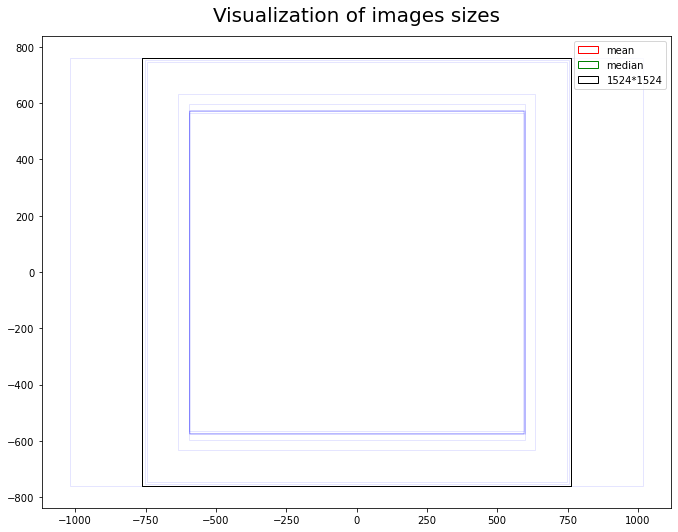

In [25]:
# to show the variation in size of the images (inspired from the code of Pierre Vuillecard)
fig, ax = plt.subplots(1,1,figsize=(13,7.5))
fig.suptitle('Visualization of images sizes', fontsize=20)

#add rectangle to plot
ax.plot([0, 0],[0, 0])
for j, row in sizes_df.iterrows():
    x = row['width']
    y = row['height']
    if x > y:
        x = row['height']
        y = row['width']
    ax.add_patch(Rectangle((-y/2, -x/2), y, x,
                edgecolor = 'blue',
                facecolor = 'cyan',
                fill=False,
                alpha = 0.1))
    
perf_mean= {'x':sizes_df["width"].mean(), 'y':sizes_df["height"].mean()}
perf_median= {'x':sizes_df["width"].median(), 'y':sizes_df["height"].median()}
ax.add_patch(Rectangle((-perf_mean['y']/2, -perf_mean['x']/2), perf_mean['y'], perf_mean['x'],
            edgecolor = 'red',
            fill=False,
            alpha = 1,label ='mean'))
ax.add_patch(Rectangle((-perf_median['y']/2, -perf_median['x']/2), perf_median['y'], perf_median['x'],
            edgecolor = 'green',
            fill=False,
            alpha = 1,label = 'median'))
ax.add_patch(Rectangle((-1524/2, -1524/2), 1524, 1524,
            edgecolor = 'black',
            fill=False,
            alpha = 1,label = '1524*1524'))  
ax.legend()

ax.set(adjustable='box', aspect='equal')
fig.tight_layout()

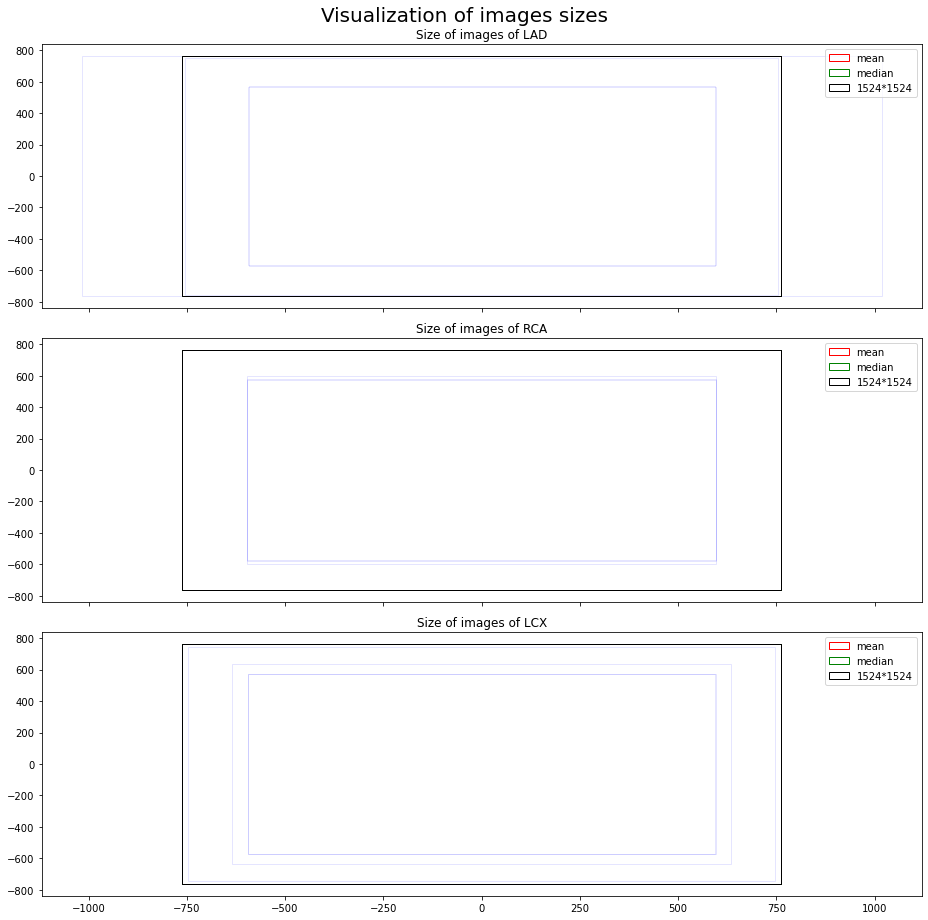

In [26]:
# to show the variation in size of the images (inspired from the code of Pierre Vuillecard)
fig, ax = plt.subplots(3,1,figsize=(13,13), sharex=True)
fig.suptitle('Visualization of images sizes', fontsize=20)

for i, artery in enumerate(["LAD", "RCA", "LCX"]):
    df = sizes_df[sizes_df["artery"] == artery]
    
    #add rectangle to plot
    ax[i].plot([0, 0],[0, 0])
    for j, row in df.iterrows():
        x = row['width']
        y = row['height']
        if x > y:
            x = row['height']
            y = row['width']
        ax[i].add_patch(Rectangle((-y/2, -x/2), y, x,
                    edgecolor = 'blue',
                    facecolor = 'cyan',
                    fill=False,
                    alpha = 0.1))

    perf_mean= {'x':df["width"].mean(), 'y':df["height"].mean()}
    perf_median= {'x':df["width"].median(), 'y':df["height"].median()}
    ax[i].add_patch(Rectangle((-perf_mean['y']/2, -perf_mean['x']/2), perf_mean['y'], perf_mean['x'],
                edgecolor = 'red',
                fill=False,
                alpha = 1,label ='mean'))
    ax[i].add_patch(Rectangle((-perf_median['y']/2, -perf_median['x']/2), perf_median['y'], perf_median['x'],
                edgecolor = 'green',
                fill=False,
                alpha = 1,label = 'median'))
    ax[i].add_patch(Rectangle((-1524/2, -1524/2), 1524, 1524,
                edgecolor = 'black',
                fill=False,
                alpha = 1,label = '1524*1524'))  
    ax[i].legend()
    ax[i].set_title("Size of images of "+artery)
    
fig.tight_layout()

In [20]:
pd.read_csv("dl_artery_level_df_bigger.csv")

,patient_name,mi_lad,mi_lcx,mi_rca,patient_mi
0,patient1,0,0,0,0
1,patient10,0,1,0,1
2,patient100,0,0,0,0
3,patient101,0,0,0,0
4,patient102,0,0,0,0
...,...,...,...,...,...
440,patient95,0,0,0,0
441,patient96,0,0,0,0
442,patient97,0,0,0,0
443,patient98,0,0,0,0


## 2. Create the attention images

In [32]:
def multivariate_gaussian(pos, mu, Sigma):
    """
    Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    
    Credits: This snippet of code is taken from the Master Project of Pierre Vuillecard
    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

In [33]:
def add_gaussian_on_img(img, mu_original, Sigma):
    """
    Return an image with a white gaussian added on top of it
    
    img: the original img
    mu & Sigma: gaussian parameters
    
    Credits: This snippet of code is inspired from the Master Project of Pierre Vuillecard
    """
    
    Y = np.linspace(0, img.shape[0]-1 , img.shape[0])
    X = np.linspace(0, img.shape[1]-1 , img.shape[1])
    X, Y = np.meshgrid(X, Y)
    
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    Z = multivariate_gaussian(pos, mu_original, Sigma)
    Z = Z/np.max(Z)*255
    
    img[:,:,0] = np.max([img[:,:,0], Z], axis=0)
    img[:,:,1] = np.max([img[:,:,1], Z], axis=0)
    img[:,:,2] = np.max([img[:,:,2], Z], axis=0)
    
    img[img>255] = 255 
    
    return img

In [34]:
def find_gaussian_from_rect(rect):
    """
    Return the parameters of a guassian based on a rectangle to cover on the image
    
    rect: list of positions of the corners of the rectangle
    
    Credits: This snippet of code is inspired from the Master Project of Pierre Vuillecard
    """
    
    rect = np.asarray(rect)
    rect = cv2.minAreaRect(rect.astype(int))
    
    theta_original = np.radians(rect[2])
    rot = np.array(( (np.cos(theta_original), -np.sin(theta_original)),
                                (np.sin(theta_original),  np.cos(theta_original)) ))
    
    mu_original = np.array([rect[0][0], rect[0][1]])
    Sigma = rot@np.array([[ (rect[1][0]/2)**2 , 0], [0,  (rect[1][1]/2)**2]])@rot.T

    return mu_original, Sigma

In [37]:
def create_artery_mask_imgs(patient_row, resize=None, 
                            basepath=None, save_original=True, save_mask=True,
                            debug=False):
    """
    Create a mask images that shows only the arteries of the image
    
    patient_row: row of the dataframe containing the path to the images and the coordinate of the boxes
    resize: resize the images or not (None to avoid, else give tuple (width, height))
    basepath: path to the folder of the patient
    save_original: save or not the original
    save_mask: save or not the mask
    debug: plot or no the image with boxes and the mask
    """

    list_of_img_type = ["path_lad_1", "path_lad_2", "path_rca_1", "path_rca_2", "path_lcx_1", "path_lcx_2"]
    list_of_boxes_type = ["boxes_lad_1", "boxes_lad_2", "boxes_rca_1", "boxes_rca_2", "boxes_lcx_1", "boxes_lcx_2"]
    
    for img_type, rect_type in zip(list_of_img_type,list_of_boxes_type):
        if debug:
            print(img_type)
        
        img_path = patient_row[img_type]
        
        img = mpimg.imread(img_path)
        
        if img.shape[-1] == 4 :
            img = img[:,:,:-1]
        
        if resize is not None:
            img = cv2.resize(img, resize)
            
        if save_original:
            full_path = basepath + "/" + img_type[5:] + ".pkl"
            with open(full_path, 'wb') as f:
                pickle.dump(img, f)
        
        if debug:
            name = img_path[:-10]
            name += ".tif"
            img_debug = mpimg.imread(name)
            plt.imshow(img_debug)
            plt.show()

        # Create a black image with same dimensions and remove the 4th color if present (transparency)
        img_msk = img.copy()
        img_msk[:,:,0] = 0
        img_msk[:,:,1] = 0
        img_msk[:,:,2] = 0 

        for rect in patient_row[rect_type]:   
            mu_original, Sigma = find_gaussian_from_rect(rect)
            img_msk = add_gaussian_on_img(img_msk, mu_original, Sigma)
        
        if save_mask:
            full_path = basepath + "/" + img_type[5:] + "_mask.pkl"
            with open(full_path, 'wb') as f:
                pickle.dump(img_msk, f)
        
        if debug:
            plt.imshow(img_msk)
            plt.show()

path_lad_1


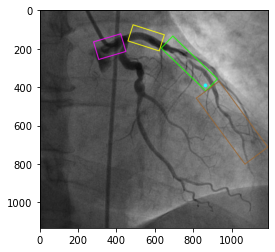

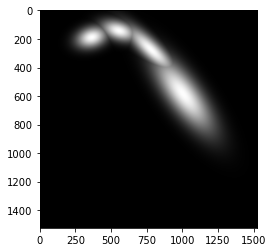

path_lad_2


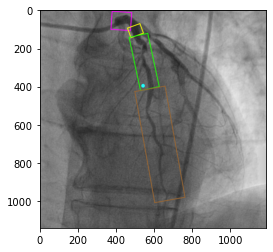

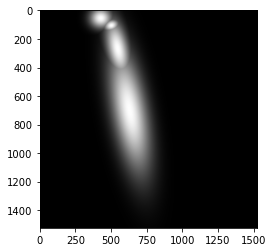

path_rca_1


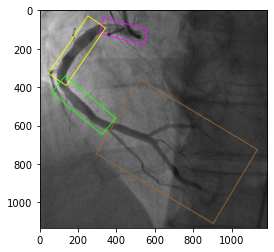

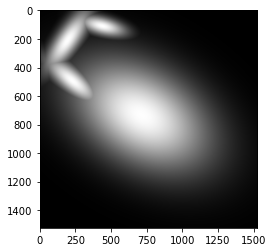

path_rca_2


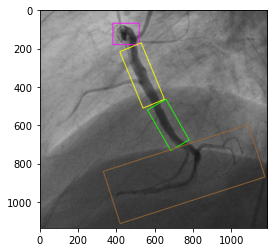

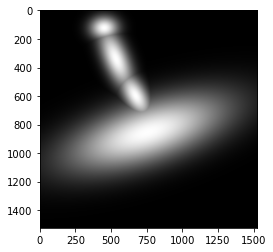

path_lcx_1


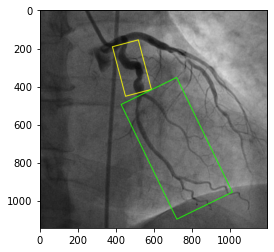

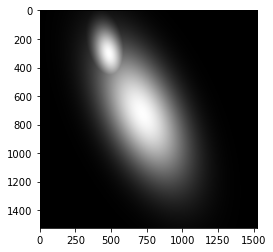

path_lcx_2


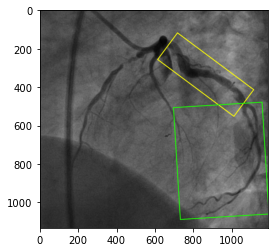

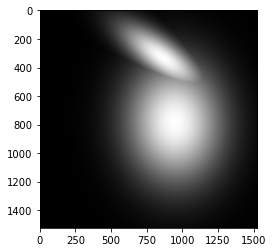

In [38]:
# Code to test if it seems to work
create_artery_mask_imgs(artery_level_df.iloc[0], resize=(1524, 1524), basepath="test_folder", debug=True,
                       save_original=False, save_mask=False)

In [39]:
def plot_imgs(tensor):
    fig, axs = plt.subplots(3, 4, figsize=(15,5))
    
    for i_artery, artery in enumerate(["lad", "lcx", "rca"]):
            for i_view, view in enumerate(["1", "2"]):
    
                axs[i_artery, 2*i_view].imshow(tensor[i_artery, i_view, 0, :, :], cmap='gray')
                axs[i_artery, 2*i_view].set_title(artery+" "+view+" raw")
                axs[i_artery, 2*i_view].axis('off')

                axs[i_artery, 2*i_view+1].imshow(tensor[i_artery, i_view, 1, :, :], cmap='gray')
                axs[i_artery, 2*i_view+1].axis('off')
    
    fig.tight_layout()
    plt.show()

In [40]:
def create_patient_tensor(patient_row, resize=None, 
                            basepath=None, save=True, plot=False):
    """
    Create a tensor with all the images of the patient 
    shape (3, 2, 2, 1524, 1524) (artery, view, mask/original/img size)
    """
    
    to_tensor = transforms.ToTensor()

    all_img_patient = torch.empty((3, 2, 2, 1524, 1524))
    
    for i_artery, artery in enumerate(["lad", "lcx", "rca"]):
            for i_view, view in enumerate(["1", "2"]):
                img_path = patient_row["path_"+artery+"_"+view]
                
                img = mpimg.imread(img_path)
        
                if img.shape[-1] == 4 :
                    img = img[:,:,:-1]

                if resize is not None:
                    img = cv2.resize(img, resize)
                    
                # Create a black image with same dimensions and remove the 4th color if present (transparency)
                img_msk = img.copy()
                img_msk[:,:,0] = 0
                img_msk[:,:,1] = 0
                img_msk[:,:,2] = 0 

                for rect in patient_row["boxes_"+artery+"_"+view]:   
                    mu_original, Sigma = find_gaussian_from_rect(rect)
                    img_msk = add_gaussian_on_img(img_msk, mu_original, Sigma)
                    
                # Only take graylevel
                img = img[:, :, 0]
                img_msk = img_msk[:, :, 0]
                    
                all_img_patient[i_artery, i_view, 0, :, :] = to_tensor(img)
                all_img_patient[i_artery, i_view, 1, :, :] = to_tensor(img_msk)
                    
    if save:
        os.mkdir(basepath+"/"+patient_row.name)
        torch.save(all_img_patient, basepath+"/"+patient_row.name+'/patient_tensor.pt')
        
    if plot:
        plot_imgs(all_img_patient)

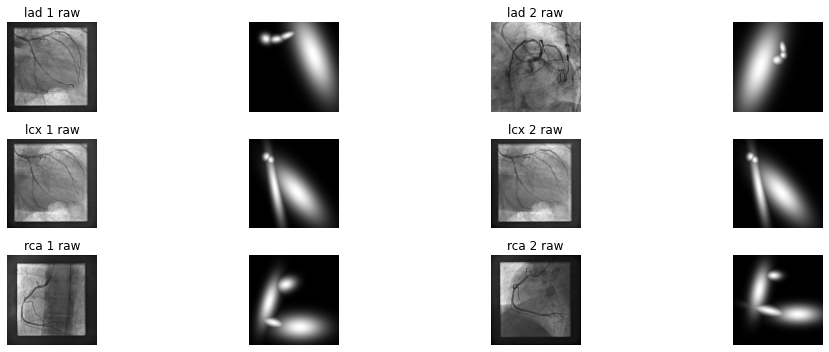

In [42]:
import torchvision.transforms as transforms

create_patient_tensor(artery_level_df.iloc[1], resize=(1524, 1524), 
                        basepath="test_folder", save=True, plot=True)

torch.Size([3, 2, 2, 1524, 1524])


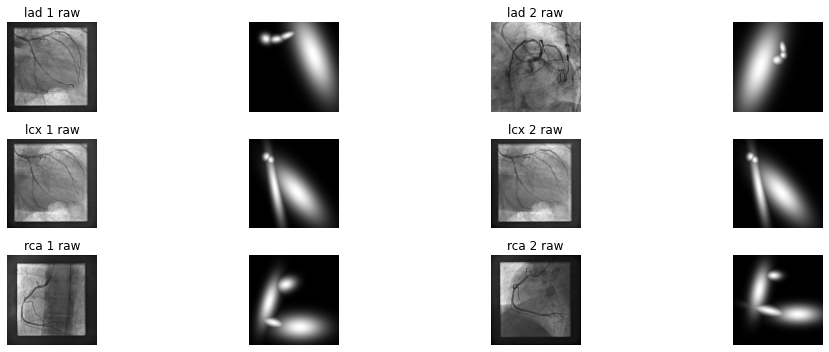

In [44]:
import torch
patient_tensor = torch.load("test_folder/patient10/patient_tensor.pt")
print(patient_tensor.shape)
plot_imgs(patient_tensor)

In [46]:
# Create the whole dataset
start_time = time()
for i, (index, row) in enumerate(artery_level_df.iterrows()):   
    if i%50 == 0:
        curr_time = time()
        print(i, str(curr_time-start_time))
        start_time = time()
        
    try:
        create_patient_tensor(row, resize=(1524, 1524), 
                        basepath="patient_tensor_bigger", save=True, plot=False)
    except Exception as e:
        print(e)

0 9.5367431640625e-07
50 3.337860107421875e-06
100 2.1457672119140625e-06
150 1.430511474609375e-06
200 1.9073486328125e-06
250 2.384185791015625e-06
300 2.384185791015625e-06
350 2.86102294921875e-06
400 1.430511474609375e-06


## 3. Create the df with MI state for the DL training

In [47]:
dl_artery_level_df = artery_level_df[["mi_lad", "mi_lcx", "mi_rca", "patient_mi"]]
dl_artery_level_df.sample(3)

,mi_lad,mi_lcx,mi_rca,patient_mi
patient_name,,,,
patient403,0,0,0,0
patient59,0,0,0,0
patient287,0,0,0,0


In [48]:
#with open("dl_artery_level_df.pkl", 'wb') as f:
#    pickle.dump(dl_artery_level_df, f)
dl_artery_level_df.to_csv("dl_artery_level_df_bigger.csv")

In [51]:
pd.read_csv("dl_artery_level_df_bigger.csv", index_col=0)["patient_mi"]

patient_name
patient1      0
patient10     1
patient100    0
patient101    0
patient102    0
             ..
patient95     0
patient96     0
patient97     0
patient98     0
patient99     0
Name: patient_mi, Length: 445, dtype: int64

In [1]:
import pandas as pd 
pd.read_csv("dl_artery_level_df_bigger.csv", index_col=0)

,mi_lad,mi_lcx,mi_rca,patient_mi
patient_name,,,,
patient1,0,0,0,0
patient10,0,1,0,1
patient100,0,0,0,0
patient101,0,0,0,0
patient102,0,0,0,0
...,...,...,...,...
patient95,0,0,0,0
patient96,0,0,0,0
patient97,0,0,0,0


---